In [30]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.utils.data as tdata

### Load the Dataset

- Split full dataset into X, y

In [31]:
# 'SS20_Full-edit.csv' has upper arm circumference L/R removed
raw_data = pd.read_csv('/Users/rileyoest/VS_Code/VS_PLATFORM/PenningtonProject/Data/SS20_Full.csv')
df = raw_data[['ALM (adjusted)',  *raw_data.columns[9:]]]

# Comment this out to run model on perfect dataset
# df = df.dropna()

X = df.iloc[:, 1:]
y = df.iloc[:, 0]

df.describe()

,ALM (adjusted),Weight (kg),Abdomen Circumference,Ankle Circumference Left,Arm Length Left,Arm Volume Left,Bicep Circumference Left,Calf Circumference Left,Chest,Collar Circumference,...,Calf Circumference Right,Forearm Circumference Right,Inseam Right,Leg Volume Right,MidThigh Circumference Right,Outside Leg Length Right,Surface Area Arm Right,Surface Area Leg Right,Thigh Circumference Right,Upper Arm Circumference Right
count,769.000000,769.000000,762.000000,762.000000,753.000000,754.000000,763.000000,762.000000,752.000000,752.000000,...,760.000000,760.000000,769.000000,757.000000,761.000000,765.000000,751.000000,767.000000,759.000000,656.000000
mean,18.860468,66.236671,92.355688,22.785432,55.495576,3617.804025,30.400735,35.357157,92.163289,35.634733,...,35.463084,25.724083,72.094047,8014.536831,44.163176,96.648039,1453.475410,3919.573872,54.966281,31.646380
std,7.236510,25.199892,18.008377,2.566588,6.162589,1219.685466,6.359976,5.368982,18.342566,5.296689,...,5.124478,4.048834,8.000637,2550.708073,7.675878,11.300550,322.788313,783.144124,9.532233,6.233158
min,4.200000,17.400000,50.924000,16.005000,34.530000,1051.510000,15.341000,22.533000,53.909000,23.966000,...,22.195000,16.090000,41.199000,1659.358000,24.291000,55.030000,533.250000,1546.544000,25.662000,16.324000
25%,13.600000,49.600000,80.737000,21.028750,52.400000,2748.165750,25.529500,32.166750,79.391750,31.556250,...,32.350000,22.750000,68.491000,6417.100000,39.472000,91.690000,1255.073500,3533.265000,48.645500,27.592500
50%,18.200000,65.200000,91.586500,22.850000,56.200000,3535.660000,30.020000,35.317000,91.068500,34.792500,...,35.735000,25.364000,73.464000,8069.725000,43.800000,98.835000,1458.152000,4045.770000,55.100000,31.651500
75%,23.900000,81.600000,103.750000,24.478250,59.558000,4482.178250,34.850000,38.990000,104.724250,39.124500,...,38.800000,28.602500,77.350000,9792.550000,49.000000,104.050000,1681.850000,4458.506000,61.300000,35.985000
max,38.500000,152.700000,148.650000,30.000000,69.105000,7375.350000,49.342000,50.927000,146.450000,53.590000,...,50.545000,36.700000,94.020000,15213.450000,67.780000,123.485000,2278.235000,5777.725000,80.272000,49.022000


In [32]:
np.isnan(X).sum().sum()

574

## Create Dataset Wrapper

In [33]:
# Convert DataFrame to DataLoader

class CSVDataset(tdata.Dataset):
    def __init__(self, X, y):
        # X = df.iloc[:, 1:].values
        # y = df.iloc[:, 0].values.reshape((-1, 1))

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.reshape((-1, 1)), dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

### Standardize and Split the Dataset

- Split the data into train/test X, y
- Standardize X_train and X_test exclusively using X_train data with no missing values

<AxesSubplot:>

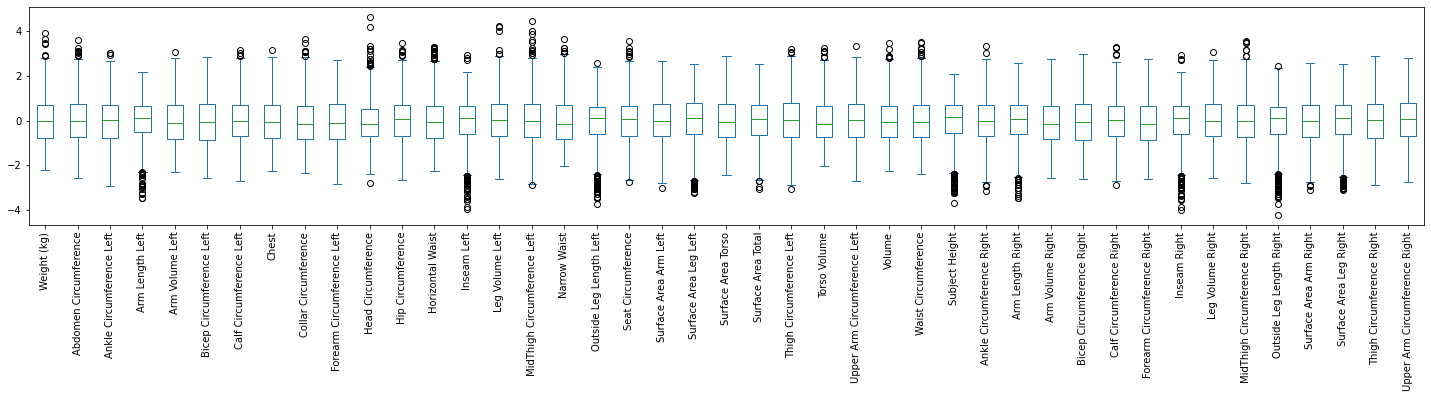

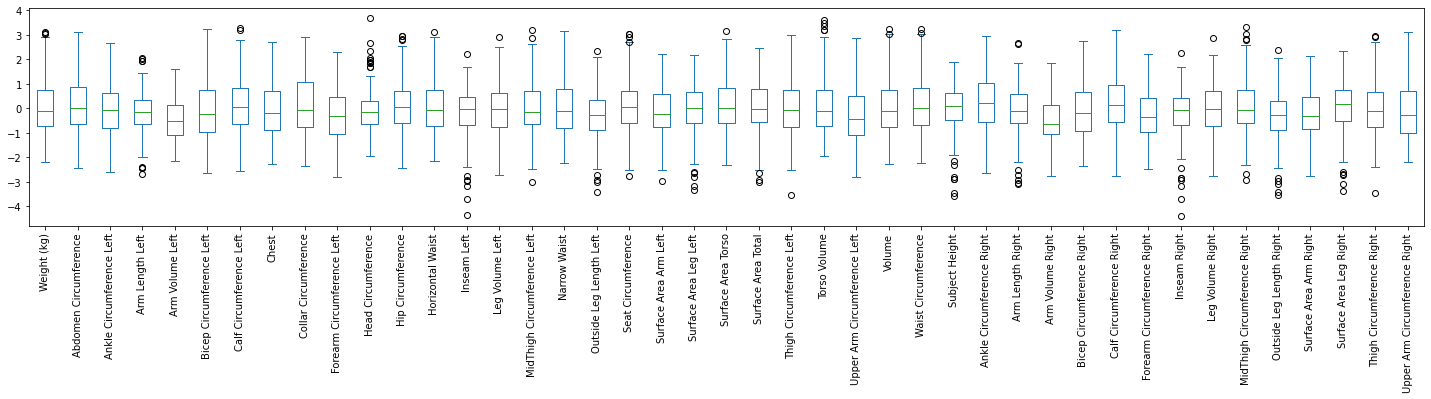

In [34]:
from sklearn.preprocessing import StandardScaler

# Split training and test values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle=False)

# Standardize training X values (mean=0; std=1)
scale = StandardScaler().fit(X_train.dropna())

X_train_std = pd.DataFrame(scale.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_std = pd.DataFrame(scale.transform(X_test), columns=X_test.columns)

# Bypass standardization 
# X_train_std = X_train
# X_test_std = X_test

X_train_std.plot.box(figsize=(25,4), rot=90)
X_test_std.plot.box(figsize=(25,4), rot=90)


### Fill Mising Values
- Using the median of each individual's standardized inputs as to maintain a rough idea of how different they are from an average person.

- This could be accomplished by filling column-wise averages or filling all 0's

In [35]:
# Save unfilled datasets as .csv

# df_train = pd.concat([
#     y_train, 
#     X_train_std
#     ], axis=1)

# df_train.to_csv('./std-data/missing/yX_train.csv')
# X_train_std.to_csv('./std-data/missing/X_train_std.csv')
# y_train.to_csv('./std-data/missing/y_train.csv')

# df_test = pd.concat([
#     y_test, 
#     X_test_std
#     ], axis=1)

# df_test.to_csv('./std-data/missing/yX_test.csv')
# X_test_std.to_csv('./std-data/missing/X_test_std.csv')
# y_test.to_csv('./std-data/missing/y_test.csv')

In [36]:
print("NaN in Train, Test:", X_train_std.isna().sum().sum(), X_test_std.isna().sum().sum())
for column in X_train.columns:
    if 'Left' in column:
        other = column.replace('Left', 'Right')
        X_train_std[column] = X_train_std[column].fillna(X_train_std[other])
        X_test_std[column] = X_test_std[column].fillna(X_test_std[other])
    elif 'Right' in column:
        other = column.replace('Right', 'Left')
        X_train_std[column] = X_train_std[column].fillna(X_train_std[other])    
        X_test_std[column] = X_test_std[column].fillna(X_test_std[other])    
print("NaN in Train, Test:", X_train_std.isna().sum().sum(), X_test_std.isna().sum().sum())


# Fill with MICE (sklearn)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice = IterativeImputer(max_iter=500, tol=0.001)
X_train_std = pd.DataFrame(mice.fit_transform(X_train_std), columns=X_train_std.columns)
X_test_std = pd.DataFrame(mice.transform(X_test_std), columns=X_test_std.columns)

print("NaN in Train, Test:", X_train_std.isna().sum().sum(), X_test_std.isna().sum().sum())


NaN in Train, Test: 412 162
NaN in Train, Test: 264 141
NaN in Train, Test: 0 0


In [37]:

# Save filled datasets as .csv

# df_train = pd.concat([
#     y_train, 
#     X_train_std
#     ], axis=1)

# df_train.to_csv('./std-data/row-median-filled/yX_train-filled.csv')
# X_train_std.to_csv('./std-data/row-median-filled/X_train_std-filled.csv')

# df_test = pd.concat([
#     y_test, 
#     X_test_std
#     ], axis=1)

# df_test.to_csv('./std-data/row-median-filled/yX_test-filled.csv')
# X_test_std.to_csv('./std-data/row-median-filled/X_test_std-filled.csv')

### Run the Model
- Define the model

In [38]:
# Hyperparameters
learning_rate = 0.001
epochs = 1000
batch_size = 32

# Shape
input_layer, output_layer = X_train_std.shape[1], 1
hidden_layers = [41, 86]
# hidden_layers = [input_layer, input_layer*2]

model = nn.Sequential(
    nn.Linear(input_layer, hidden_layers[0]),
    nn.Dropout(p=0.4),
    nn.ReLU(),
    nn.Linear(hidden_layers[0], hidden_layers[1]),
    nn.Dropout(p=0.25),
    nn.ReLU(),
    nn.Linear(hidden_layers[1], output_layer)
)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

### Training

In [39]:
from IPython import display

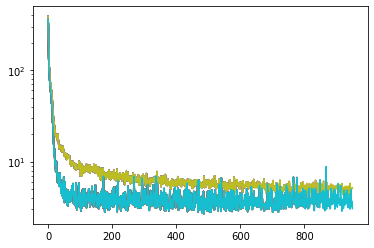

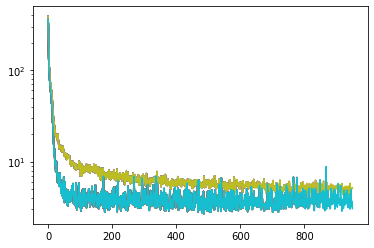

In [40]:
def _train_epoch(batches):
    batch_loss = 0.0
    
    model.train()
    for X, y in batches:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
    
    return batch_loss / len(batches)


def _validate_epoch(batches):
    batch_loss = 0.0
    
    model.eval()
    with torch.no_grad():
        for X, y in batches:
            y_pred = model(X)
            batch_loss += criterion(y_pred, y).item()
            
    return batch_loss / len(batches)


def train_model(X, y):
    # Split train/validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.1, random_state=42, shuffle=True)
    
    # Convert datasets to DataLoaders
    train_dl = tdata.DataLoader(CSVDataset(X_train.values, y_train.values), shuffle=True, batch_size=batch_size)
    valid_dl = tdata.DataLoader(CSVDataset(X_valid.values, y_valid.values), shuffle=True)

    training_losses = []
    validation_losses = []
    
    best_validation_loss = np.inf
    best_model = None
    
    # Train
    for epoch in range(epochs):
        train_loss = _train_epoch(train_dl)
        validate_loss = _validate_epoch(valid_dl)
        
        training_losses.append(train_loss)
        validation_losses.append(validate_loss)
        
        if best_validation_loss > validate_loss:
            best_validation_loss = validate_loss
            best_model = deepcopy(model)
            
        # print(f'Epoch {epoch}: {train_loss}, {validate_loss}, {best_validation_loss}')
        
        if epoch % 50 == 0:
            plt.plot(range(len(training_losses)), training_losses, label='Training loss')
            plt.plot(range(len(validation_losses)), validation_losses, label='Validation loss')
            # plt.legend()
            # plt.axvline(x=validation_losses.index(min(validation_losses)), c='k', label=f'Min Valid Loss: {round(min(validation_losses), 3)}')
            plt.yscale('log')
            display.clear_output(wait=True)
            display.display(plt.gcf())

    return training_losses, validation_losses, best_model
        
training_losses, validation_losses, best_model = train_model(X_train_std, y_train)

### Evaluation

In [41]:
def evaluate_model(model):
    model.eval()
    
    test_dl = tdata.DataLoader(CSVDataset(X_test_std.values, y_test.values), shuffle=True)
    real_vals = []
    pred_vals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dl:
            # There is only one batch
            X, y = X_batch[0], y_batch[0]
            
            y_pred = model(X)
            real_vals.append(y.item())
            pred_vals.append(y_pred.item())
    
    diffs = np.array([abs(real - pred) for real, pred in zip(real_vals, pred_vals)])
    df = pd.DataFrame({'Actual': real_vals, 'Predicted': pred_vals, 'Difference': diffs})
    
    return df

model = best_model
df = evaluate_model(model)

### Results

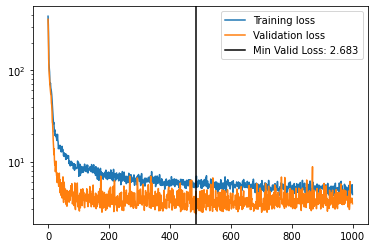

In [42]:
# Plot losses
# Overfitting article: 
# https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html
# -x Simplify model
# -x Stop early
# - Data augmentation
# -x Regularization (L2)
# -x Dropout

plt.plot(range(len(training_losses)), training_losses, label='Training loss')
plt.plot(range(len(validation_losses)), validation_losses, label='Validation loss')
plt.axvline(x=validation_losses.index(min(validation_losses)), c='k', label=f'Min Valid Loss: {round(min(validation_losses), 3)}')
plt.yscale('log')
plt.legend()

Mean 1.4882142946317598; Median 1.1743602752685547; Max 5.941827774047852; Std 1.224311884931395;


<AxesSubplot:>

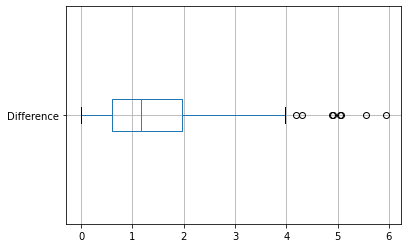

In [43]:
diffs = df['Difference']

print(f'Mean {diffs.mean()}; Median {diffs.median()}; Max {diffs.max()}; Std {diffs.std()};')
diffs.to_frame().boxplot(vert=False)

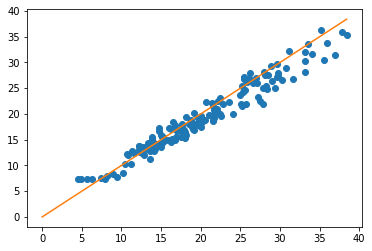

In [44]:
ax1 = df['Actual']
ax2 = df['Predicted']
plt.plot(ax1, ax2, 'o')
biggest = max(ax1.max(), ax2.max())
plt.plot(np.linspace(0, biggest), np.linspace(0, biggest))

In [45]:
# torch.save(model, './best_model.pth')